# Predict extreme snowmelt events in climate change scenarios

In [70]:
import pandas as pd
import numpy as np
import geopandas as gpd
from collections import Counter
import os

from imblearn.under_sampling import NearMiss

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from matplotlib import pyplot as plt
import seaborn as sns


In [71]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series


### Train best model from previous analysis

Model was the random forest model with precipitation data (['prec__sum_values', 'prec__median', 'prec__standard_deviation', 'prec__variance', 'prec__minimum'])
Time window 2 days and prediction horizon 10 days. Time evaluation, minimal time series parameters and no year included.
AUC-PR score 0.890

In [72]:
## Recreate rolled dataframe with minimal features and undersample it (2 days, time lag zero)
all_data_clean = pd.read_csv('../all_data_clean.csv')
df_rolled = roll_time_series(
    all_data_clean[['date', 'flow_site_id', 'prec', 'binary']], column_id="flow_site_id", column_sort="date", max_timeshift=2, min_timeshift=2 - 1, n_jobs=20)
X_features_all = extract_features(
	df_rolled.drop(["binary", "flow_site_id"], axis=1), column_id='id', column_sort='date',
	n_jobs=20, disable_progressbar=False, default_fc_parameters=MinimalFCParameters())


Feature Extraction: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


In [73]:
X_features_all['unique_id'] = X_features_all.index

all_data_clean['shifted_date'] = pd.to_datetime(
    all_data_clean.date) + pd.Timedelta(days=10)
all_data_clean['shifted_date'] = all_data_clean['shifted_date'].dt.strftime(
    '%Y-%m-%d')
all_data_clean['unique_id'] = list(
    zip(all_data_clean.flow_site_id, all_data_clean.shifted_date))
all_data_clean = all_data_clean.dropna()

X_features_all = X_features_all.reset_index(drop=True)

X_features_all = pd.merge(X_features_all, all_data_clean[[
                          'binary', 'unique_id']], how='left', on='unique_id')
X_features_all = X_features_all.set_index(
    X_features_all['unique_id'], drop=True)
X_features_all = X_features_all.dropna()
X_features_all.head()


,prec__sum_values,prec__median,prec__mean,prec__length,prec__standard_deviation,prec__variance,prec__root_mean_square,prec__maximum,prec__minimum,unique_id,binary
unique_id,,,,,,,,,,,
"(114.0, 1909-01-11)",0.2,0.0,0.066667,3.0,0.094281,0.008889,0.115470,0.2,0.0,"(114.0, 1909-01-11)",0.0
"(114.0, 1909-01-12)",0.4,0.2,0.133333,3.0,0.094281,0.008889,0.163299,0.2,0.0,"(114.0, 1909-01-12)",0.0
"(114.0, 1909-01-13)",0.4,0.2,0.133333,3.0,0.094281,0.008889,0.163299,0.2,0.0,"(114.0, 1909-01-13)",0.0
"(114.0, 1909-01-14)",0.7,0.2,0.233333,3.0,0.205480,0.042222,0.310913,0.5,0.0,"(114.0, 1909-01-14)",0.0
"(114.0, 1909-01-15)",2.4,0.5,0.800000,3.0,0.804156,0.646667,1.134313,1.9,0.0,"(114.0, 1909-01-15)",0.0


In [74]:
## only keep 'prec__sum_values', 'prec__median', 'prec__standard_deviation', 'prec__variance', 'prec__minimum'
y1 = X_features_all['binary']
undersample = NearMiss(version=3, n_neighbors=3)
X_under, y_under = undersample.fit_resample(X_features_all.drop(
    columns=['binary', 'unique_id', 'prec__mean', 'prec__length', 'prec__root_mean_square', 'prec__maximum']), y1)
X_under.index = X_features_all['unique_id'][undersample.sample_indices_]
y_under.index = X_features_all['unique_id'][undersample.sample_indices_]
Counter(y_under)


Counter({0.0: 4688, 1.0: 4688})

In [75]:
## fit random forest model with parameters {'max_depth': 5, 'max_features': 2, 'n_estimators': 1500}

clf = RandomForestClassifier(max_depth= 5, max_features=2, n_estimators=1500, n_jobs=-1, random_state=42, verbose=0)
clf.fit(X_under, y_under)
present_all = clf.predict(X_under)
len(present_all)


9376

### Look at feature importance and values

Text(0, 0.5, 'Feature importance')

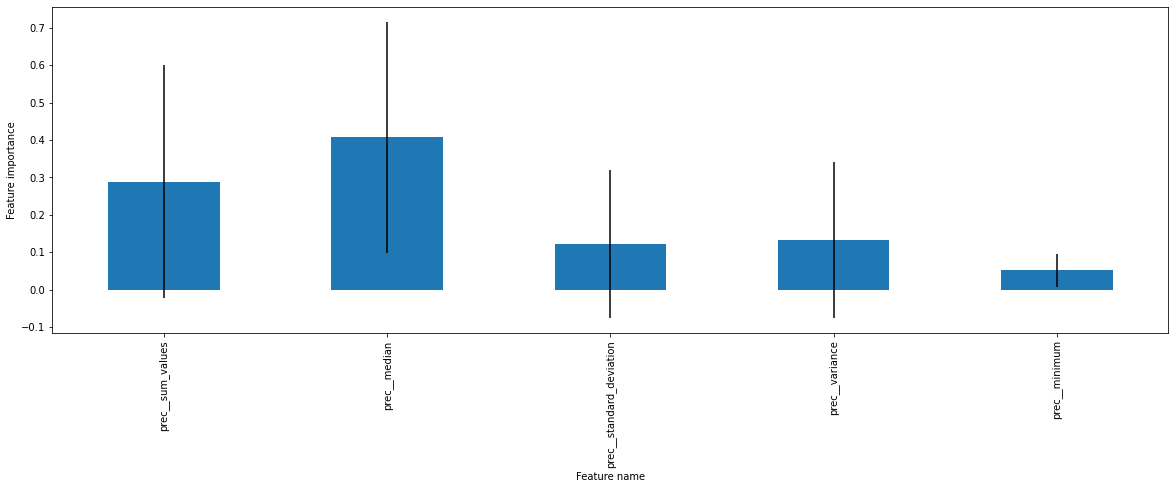

In [77]:
## check feature importance

importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=X_under.columns)

std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

plt.figure(figsize=(20, 6))
forest_importances.plot.bar(yerr=std)
plt.xlabel('Feature name')
plt.ylabel('Feature importance')

[Text(0.5, 0, 'Extreme snowmelt'), Text(0, 0.5, 'Median precipitation')]

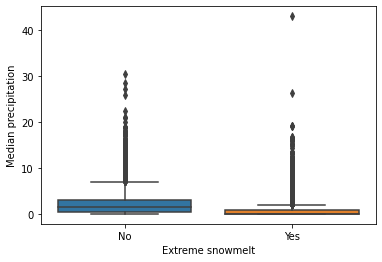

In [83]:
all_under = pd.concat([X_under, pd.DataFrame(y_under)], axis=1)
dict_map = {0.0: 'No', 1.0: 'Yes'}
all_under['binary'] = all_under['binary'].map(dict_map)
g = sns.boxplot(x="binary", y="prec__median", data=all_under)
g.set(xlabel='Extreme snowmelt', ylabel='Median precipitation (mm)')


[Text(0.5, 0, 'Extreme snowmelt'), Text(0, 0.5, 'Total precipitation')]

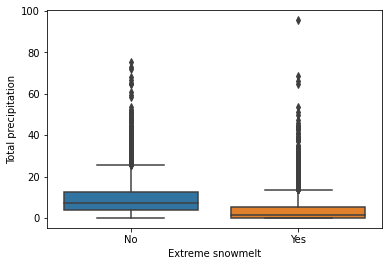

In [84]:
g = sns.boxplot(x="binary", y="prec__sum_values", data=all_under)
g.set(xlabel='Extreme snowmelt', ylabel='Total precipitation (mm)')

[Text(0.5, 0, 'Extreme snowmelt'),
 Text(0, 0.5, 'Standard deviation of precipitation')]

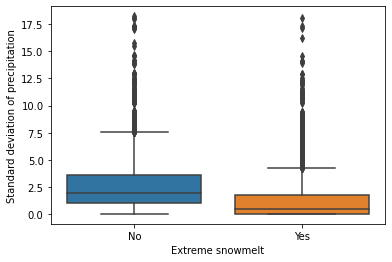

In [85]:
g = sns.boxplot(x="binary", y="prec__standard_deviation", data=all_under)
g.set(xlabel='Extreme snowmelt', ylabel='Standard deviation of precipitation (mm)')

[Text(0.5, 0, 'Extreme snowmelt'),
 Text(0, 0.5, 'Variance of precipitation (mm)')]

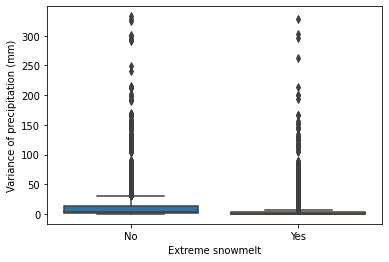

In [86]:
g = sns.boxplot(x="binary", y="prec__variance", data=all_under)
g.set(xlabel='Extreme snowmelt', ylabel='Variance of precipitation (mm)')

[Text(0.5, 0, 'Extreme snowmelt'), Text(0, 0.5, 'Minimum precipitation (mm)')]

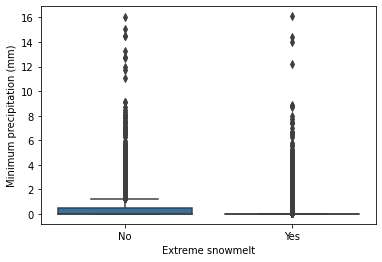

In [87]:
g = sns.boxplot(x="binary", y="prec__minimum", data=all_under)
g.set(xlabel='Extreme snowmelt', ylabel='Minimum precipitation (mm)')

### When does the model work well? When does it not?

In [ ]:
def auc_pr_score(y_true, y_pred):
	precision, recall, _ = precision_recall_curve(y_true, y_pred)
	return auc(recall, precision)


In [ ]:
print(confusion_matrix(y_under, present_all))
print(auc_pr_score(y_under, present_all))
model_error = round((1 - auc_pr_score(y_under, present_all)) * 100, 2)
print('Model error is: ', model_error, '%')


[[4498  190]
 [1879 2809]]
0.8681201292068915
Model error is:  13.19 %


In [ ]:
present = pd.DataFrame(present_all)
present.columns = ['prediction']
present.index = X_under.index
all_pred = pd.concat([all_under, present], axis=1)
all_pred['classification_short'] = all_pred['binary'].astype(str) + all_pred['prediction'].astype(str)
value_dict = {'0.00.0': 'true negatives', '0.01.0': 'false positives', '1.00.0': 'false negatives', '1.01.0': 'true positives'}
all_pred['classification'] = all_pred['classification_short'].map(value_dict)


[Text(0.5, 0, 'Classification'), Text(0, 0.5, 'Median precipitation (mm)')]

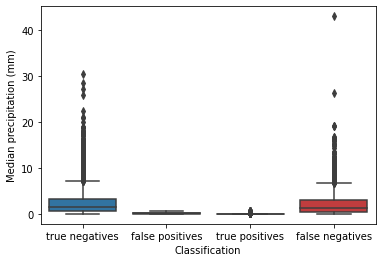

In [88]:
g = sns.boxplot(x="classification", y="prec__median", data=all_pred)
g.set(xlabel='Classification', ylabel='Median precipitation (mm)')

[Text(0.5, 0, 'Classification'), Text(0, 0.5, 'Total precipitation (mm)')]

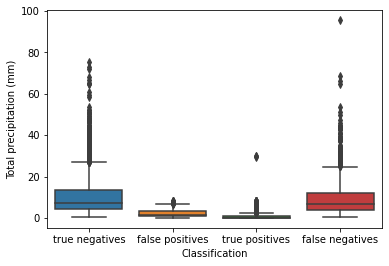

In [89]:
g = sns.boxplot(x="classification", y="prec__sum_values", data=all_pred)
g.set(xlabel='Classification', ylabel='Total precipitation (mm)')

[Text(0.5, 0, 'Classification'),
 Text(0, 0.5, 'Standard deviation of precipitation (mm)')]

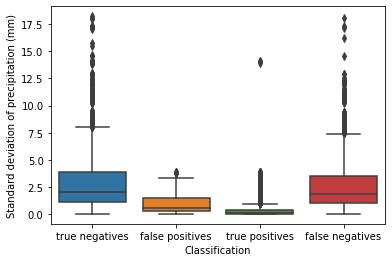

In [90]:
g = sns.boxplot(x="classification", y="prec__standard_deviation", data=all_pred)
g.set(xlabel='Classification', ylabel='Standard deviation of precipitation (mm)')

[Text(0.5, 0, 'Classification'),
 Text(0, 0.5, 'Variance of precipitation (mm)')]

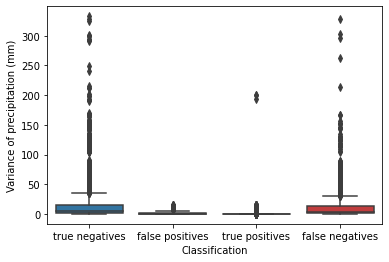

In [91]:
g = sns.boxplot(x="classification", y="prec__variance", data=all_pred)
g.set(xlabel='Classification', ylabel='Variance of precipitation (mm)')

[Text(0.5, 0, 'Classification'), Text(0, 0.5, 'Minimum precipitation (mm)')]

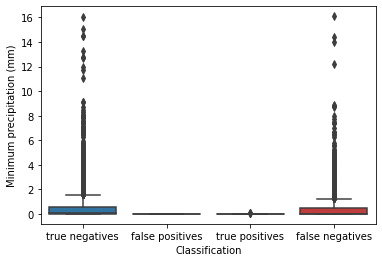

In [92]:
g = sns.boxplot(x="classification", y="prec__minimum", data=all_pred)
g.set(xlabel='Classification', ylabel='Minimum precipitation (mm)')

### Create scenario data and predict extreme snowmelt for those

In [ ]:
# get all scenario files and produce one dataframe with site id and scenario columns

files = [file for file in os.listdir('../prec_monthly/') if file.startswith('joined')]
files_26 = [file for file in files if '26' in file]
files_45 = [file for file in files if '45' in file]
files_85 = [file for file in files if '85' in file]

ranges_26 = pd.DataFrame(columns=['site_id', 'range', 'month'])
for file in files_26:
	month = file.split('_')[-3]
	df = gpd.read_file('../prec_monthly/' + file)[['site_id', 'range']]
	df['month'] = month
	df['site_id'] = df['site_id'].astype(int)
	ranges_26 = pd.concat([ranges_26, df])

ranges_45 = pd.DataFrame(columns=['site_id', 'range', 'month'])
for file in files_45:
	month = file.split('_')[-3]
	df = gpd.read_file('../prec_monthly/' + file)[['site_id', 'range']]
	df['month'] = month
	df['site_id'] = df['site_id'].astype(int)
	ranges_45 = pd.concat([ranges_45, df])

ranges_85 = pd.DataFrame(columns=['site_id', 'range', 'month'])
for file in files_85:
	month = file.split('_')[-3]
	df = gpd.read_file('../prec_monthly/' + file)[['site_id', 'range']]
	df['month'] = month
	df['site_id'] = df['site_id'].astype(int)
	ranges_85 = pd.concat([ranges_85, df])



In [ ]:
def get_scenario_ranges(ranges):
	X_features_all_new = pd.merge(X_under, ranges, how='left', on=['site_id', 'month'])
	X_features_all_new.index = X_under.index
	X_features_all_new.dropna(inplace=True)
	X_features_all_new['prec__sum_values'] = X_features_all_new['prec__sum_values'] + \
		(X_features_all_new['prec__sum_values'] * X_features_all_new['range'] / 100)
	X_features_all_new['prec__median'] = X_features_all_new['prec__median'] + \
		(X_features_all_new['prec__median'] * X_features_all_new['range'] / 100)
	X_features_all_new['prec__minimum'] = X_features_all_new['prec__minimum'] + \
		(X_features_all_new['prec__minimum'] * X_features_all_new['range'] / 100)
	return X_features_all_new


In [ ]:
# modify X_features_all multiplying by range and select relevant columns
X_under[['site_id', 'date']] = X_under.index.to_list()
X_under['month'] = pd.to_datetime(X_under.date).dt.strftime('%b')
X_under['month'] = X_under['month'].str.upper()

X_under_26 = get_scenario_ranges(ranges_26)
X_under_45 = get_scenario_ranges(ranges_45)
X_under_85 = get_scenario_ranges(ranges_85)


In [ ]:
rcp26_all = clf.predict(X_under_26.drop(columns=['site_id', 'date', 'month', 'range']))
rcp45_all = clf.predict(X_under_45.drop(columns=['site_id', 'date', 'month', 'range']))
rcp85_all = clf.predict(X_under_85.drop(columns=['site_id', 'date', 'month', 'range']))

In [ ]:
present_all_ratio = Counter(present_all)[1.0]/len(present_all)
rcp26_all_ratio = Counter(rcp26_all)[1.0]/len(rcp26_all)
rcp45_all_ratio = Counter(rcp45_all)[1.0]/len(rcp45_all)
rcp85_all_ratio = Counter(rcp85_all)[1.0]/len(rcp85_all)

print('Present:' + str(present_all_ratio))
print('RCP26:' + str(rcp26_all_ratio))
print('RCP45:' + str(rcp45_all_ratio))
print('RCP85:' + str(rcp85_all_ratio))

print('RCP26 percent change:' + str((rcp26_all_ratio - present_all_ratio) / present_all_ratio * 100))
print('RCP45 percent change:' + str((rcp45_all_ratio - present_all_ratio) / present_all_ratio * 100))
print('RCP85 percent change:' + str((rcp85_all_ratio - present_all_ratio) / present_all_ratio * 100))

Present:0.3198592150170648
RCP26:0.31517847455788217
RCP45:0.3093197352717804
RCP85:0.3017250732342411
RCP26 percent change:-1.4633752099131896
RCP45 percent change:-3.2950370820869166
RCP85 percent change:-5.669413583052865


In [ ]:
print('The maximum change in extreme snowmelt frequency (', round((rcp85_all_ratio - present_all_ratio) / present_all_ratio * 100, 2), 
'%) is lower than model error (', model_error, '%)')


The maximum change in extreme snowmelt frequency ( -5.67 %) is lower than model error ( 13.19 %)


### Remove data outside training range and predict again

In [ ]:
## calculate value ranges for original training data and remove scenario data that is not within the range
max_sum_values = X_under['prec__sum_values'].max()
max_median = X_under['prec__median'].max()
max_minimum = X_under['prec__minimum'].max()

to_keep = X_under_85[(X_under_85['prec__sum_values'] <= max_sum_values) & (X_under_85['prec__median'] <= max_median) & (X_under_85['prec__minimum'] <= max_minimum)]
X_present_clean = X_under[X_under.index.isin(to_keep.index)]
X_rcp26_clean = X_under_26[X_under_26.index.isin(to_keep.index)]
X_rcp45_clean = X_under_45[X_under_45.index.isin(to_keep.index)]
X_rcp85_clean = X_under_85[X_under_85.index.isin(to_keep.index)]

## predict extreme snowmelt with reduced data

present_clean = clf.predict(X_present_clean.drop(columns=['site_id', 'date', 'month']))
rcp26_clean = clf.predict(X_rcp26_clean.drop(columns=['site_id', 'date', 'month', 'range']))
rcp45_clean = clf.predict(X_rcp45_clean.drop(columns=['site_id', 'date', 'month', 'range']))
rcp85_clean = clf.predict(X_rcp85_clean.drop(columns=['site_id', 'date', 'month', 'range']))


In [ ]:
present_clean_ratio = Counter(present_clean)[1.0]/len(present_clean)
rcp26_clean_ratio = Counter(rcp26_clean)[1.0]/len(rcp26_clean)
rcp45_clean_ratio = Counter(rcp45_clean)[1.0]/len(rcp45_clean)
rcp85_clean_ratio = Counter(rcp85_clean)[1.0]/len(rcp85_clean)

print('Present clean:' + str(present_clean_ratio))
print('RCP26 clean:' + str(rcp26_clean_ratio))
print('RCP45 clean:' + str(rcp45_clean_ratio))
print('RCP85 clean:' + str(rcp85_clean_ratio))

print('RCP26 clean percent change:' + str((rcp26_clean_ratio - present_clean_ratio) / present_clean_ratio * 100))
print('RCP45 clean percent change:' + str((rcp45_clean_ratio - present_clean_ratio) / present_clean_ratio * 100))
print('RCP85 clean percent change:' + str((rcp85_clean_ratio - present_clean_ratio) / present_clean_ratio * 100))

Present clean:0.3218940052128584
RCP26 clean:0.31548653344917466
RCP45 clean:0.309622067767159
RCP85 clean:0.30201998262380536
RCP26 clean percent change:-1.9905533063427714
RCP45 clean percent change:-3.8124156545209127
RCP85 clean percent change:-6.174089068825918


In [ ]:
print('The maximum change in extreme snowmelt frequency (', round(
    (rcp85_clean_ratio - present_clean_ratio) / present_clean_ratio * 100, 2),
      '%) is lower than model error (', model_error, '%)')


The maximum change in extreme snowmelt frequency ( -6.17 %) is lower than model error ( 13.19 %)
